In [1]:
import os

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import shutil

import sys
import datetime
import pprint


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf




sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W, C
# from seismicpro.batchflow.models.tf.layers import conv_block
# from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex,
                           # , statistics_plot,
#                            seismic_plot, spectrum_plot, 
                            merge_segy_files
                           )
from seismicpro.models import UnetAtt, UnetAttGauss1, attention_loss, attention_loss_gauss, FieldMetrics


from seismicpro.batchflow.batchflow.research import Research, Option, KV
from seismicpro.batchflow.batchflow.utils import plot_results_by_config


from metric_utils import get_windowed_spectrogram_dists

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

#     'loss': (C('loss'), {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
    'body': {
        'main': {
            'encoder/num_stages': 5,
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256],
                                   kernel_size=[7, 5, 5, 5, 5],
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),

            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256][::-1],
                                   kernel_size=[7, 5, 5, 5, 5][::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5, 5][::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu,),
          },
        'attn': {
              'encoder/num_stages': 5,
              'encoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32, 64, 128],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'encoder/downsample': dict(layout='pd',
                                         pool_size=2,
                                         pool_strides=2,
                                         dropout_rate=0.05),

              'decoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32, 64, 128][::-1],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'decoder/upsample': dict(layout='ta d',
                                       kernel_size=3,
                                       strides=2,
                                       dropout_rate=0.05,
                                       activation=tf.nn.elu),
        },
    },
    'head': {'scale': 1.5},
    'train_steps': {
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': 'attention_branch'},

    }
}


In [3]:
BATCH_SIZE=64

def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw), 'lift': exp_stack(batch.lift)}

def make_data_inference(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw)}


In [4]:
def train_n_save(model, loss, train_set, model_path='./saved_models', **kwargs):

    fi = train_set.indices
    
    tindex = TraceIndex(train_set.index)
    t_train_set = SeismicDataset(tindex)
    
    train_pipeline = (t_train_set.p
                      .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                      .init_model('dynamic', model, name='unet', 
                                  config={**model_config, **{'loss': (loss, {'balance': 0.05})}})
                      .init_variable('loss', default=list())
                      .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss', 'a'))
                     )
    
    batch_size = kwargs.get('batch_size', 64)
    
    if 'n_epochs' not in kwargs and 'n_iters' not in kwargs:
        n_epochs = 1
        n_iters = None
    else:
        n_epochs = kwargs.get('n_epochs', None)
        n_iters = kwargs.get('n_iters', None)
    
    train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=n_epochs, n_iters=n_iters, drop_last=True,
                                    shuffle=True, bar=True, bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')))
    
#     tz = datetime.timezone(datetime.timedelta(hours=3))
#     path = os.path.join(model_path, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))
#     print(path)
    path = model_path

    train_pipeline.save_model_now('unet', path)
    
    loss = np.array(train_pipeline.get_variable('loss'))
    
    readme = os.path.join(path, 'README.txt')
    with open(readme, 'w') as inpf:
        inpf.write("Model name: {}\n".format(model.__name__))
        inpf.write("Avg final loss (100 points): {}\n".format(np.mean(loss[-100:])))
        inpf.write("\nConfig:\n")
        inpf.write(pprint.pformat(model_config, compact=True))
        inpf.write("\n\nAdditional Info:\n")
        inpf.write(pprint.pformat(dict(fields=list(fi), **kwargs)))
        
    return loss, path, fi


def inference(model, model_path, test_set, output_path=None, tmp_dump_path='tmp', clear=False):
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)
    
    os.makedirs(tmp_dump_path)
    
    tindex = TraceIndex(test_set.index)
    t_test_set = SeismicDataset(tindex)
    
    inference_ppl = (t_test_set.p
                     .load_model("dynamic", model, 'unet', path=model_path)
                     .init_variable('res')
                     .load(components='raw', fmt='segy', tslice=np.arange(3000))
                     .predict_model('unet', make_data=make_data_inference,
                                    fetches=['out_lift'], save_to=B('raw'))
                     .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
                           src='raw', fmt='segy', split=False)
                 )
    inference_ppl.run(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)
    
    if output_path is None:
        clear = False
        output_path = os.path.join(tmp_dump_path, 'merged.sgy')
        
    print("merging .sgy")
    merge_segy_files(output_path=output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy'))
    
    if clear:
        if os.path.exists(tmp_dump_path):
            shutil.rmtree(tmp_dump_path)        
    
    return output_path


def eval_mt(batch, *args):
    mt = FieldMetrics(batch.lift[0], batch.ml[0])
    return mt.mae(), mt.corr_coef()

def eval_dist(batch, *args):
    n_use_traces = 200
    dist_m = get_windowed_spectrogram_dists(batch.lift[0][0:n_use_traces], batch.ml[0][0:n_use_traces])
    dist = np.mean(dist_m)
    return dist

def _test(path_lift, model_out, fi):
    m_index = (FieldIndex(name='ml', path=model_out, extra_headers=['offset'])
               .merge(FieldIndex(name='lift', path=path_lift)))
    
    dset = SeismicDataset(m_index)   
    metr_pipeline = (Pipeline()
                 .init_variable('mt', default=[])
                 .init_variable('dist', default=[])
                 .load(components=('ml', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .sort_traces(src=('ml', 'lift'), dst=('ml', 'lift'), sort_by='offset')
                 .call(eval_mt, save_to=V('mt', mode='a'))
                 .call(eval_dist, save_to=V('dist', mode='a')))
    
    metr_pipeline = metr_pipeline << dset
    metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                      shuffle=False, bar=True)
    mt = np.vstack(metr_pipeline.get_variable('mt'))
    dist = np.asarray(metr_pipeline.get_variable('dist'))
    
    return np.mean(mt[:, 0]), np.mean(mt[:, 1]), np.mean(dist)
    

In [5]:
def process(model, loss_fn, splits, dataset_name, path_lift):
    losses = []
    save_res = []
    for i, split in enumerate(splits): # [ds.cv0, ds.cv1, ds.cv2, ds.cv3, ds.cv4]):
        print("Processing dataset {}, model {}, cv_split {}".format(dataset_name, model.__name__, i))
        # NB split.test is passed as train and vice versa
        loss, model_path, fi = train_n_save(model, loss_fn, split.test, model_path='./saved_models/{}/{}/{}'.format(model.__name__, dataset_name, i), n_epochs=3)
        losses.append((model.__name__, dataset_name, i, loss))
        print("mean final loss:", np.mean(loss[-100:]))

        output_path = inference(model, model_path, split.train, output_path=os.path.join(model_path, '{}_out.sgy'.format(dataset_name)), clear=True)
        print(output_path)

        mae, corr, dist = _test(path_lift, output_path, fi)
        print("mae, corr, dist")
        print(mae, corr, dist)

        save_res.append([model.__name__, dataset_name, i, mae, corr, dist])
        
    return losses, save_res

In [6]:
dataset_name = 'YL1_UKM'
path_raw = '/notebooks/data/YL1_UKM/01_NA-gr_input_prep_norm2.sgy'
path_lift = '/notebooks/data/YL1_UKM/03_NA-gr_output_lift2_agora_norm2.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
             .merge(FieldIndex(name='lift', path=path_lift)))
    
findex = FieldIndex(index)
ds = SeismicDataset(findex)
ds.cv_split()
splits = [ds.cv0, ds.cv1, ds.cv2, ds.cv3, ds.cv4]

In [7]:
losses = []
save_res = []

for model, loss in zip([UnetAtt, UnetAttGauss1], [attention_loss, attention_loss_gauss]):
    l, r = process(model, loss, splits, dataset_name, path_lift)
    losses.extend(l)
    save_res.extend(r)
    

  0%|          | 0/2865 [00:00<?, ?it/s]

Processing dataset YL1_UKM, model UnetAtt, cv_split 0


  0%|          | 0/233 [00:00<?, ?it/s]

mean final loss: 0.06829385


100%|██████████| 233/233 [24:09<00:00,  5.93s/it]


merging .sgy


100%|██████████| 233/233 [01:03<00:00,  3.02it/s]


./saved_models/UnetAtt/YL1_UKM/0/YL1_UKM_out.sgy


  0%|          | 0/2862 [00:00<?, ?it/s]

mae, corr, dist
0.06901871 0.8702623 188.48369
Processing dataset YL1_UKM, model UnetAtt, cv_split 1


  0%|          | 0/233 [00:00<?, ?it/s]

mean final loss: 0.07716212


100%|██████████| 233/233 [24:48<00:00,  6.38s/it]


merging .sgy


100%|██████████| 233/233 [01:08<00:00,  1.87it/s]


./saved_models/UnetAtt/YL1_UKM/1/YL1_UKM_out.sgy


  0%|          | 0/2859 [00:00<?, ?it/s]

mae, corr, dist
0.065486185 0.88083285 179.46333
Processing dataset YL1_UKM, model UnetAtt, cv_split 2


  0%|          | 0/233 [00:00<?, ?it/s]

mean final loss: 0.0844183


100%|██████████| 233/233 [24:47<00:00,  6.30s/it]


merging .sgy


100%|██████████| 233/233 [00:56<00:00,  4.40it/s]


./saved_models/UnetAtt/YL1_UKM/2/YL1_UKM_out.sgy


  0%|          | 0/2571 [00:00<?, ?it/s]

mae, corr, dist
0.062653 0.88633406 162.13652
Processing dataset YL1_UKM, model UnetAtt, cv_split 3


  0%|          | 0/239 [00:00<?, ?it/s]

mean final loss: 0.08075408


100%|██████████| 239/239 [26:07<00:00,  6.55s/it]


merging .sgy


100%|██████████| 239/239 [00:58<00:00,  4.32it/s]


./saved_models/UnetAtt/YL1_UKM/3/YL1_UKM_out.sgy


  0%|          | 0/2577 [00:00<?, ?it/s]

mae, corr, dist
0.064297386 0.8837772 164.41396
Processing dataset YL1_UKM, model UnetAtt, cv_split 4


  0%|          | 0/239 [00:00<?, ?it/s]

mean final loss: 0.08757274


100%|██████████| 239/239 [25:33<00:00,  6.16s/it]


merging .sgy


100%|██████████| 239/239 [00:57<00:00,  4.40it/s]


./saved_models/UnetAtt/YL1_UKM/4/YL1_UKM_out.sgy


  0%|          | 0/2865 [00:00<?, ?it/s]

mae, corr, dist
0.06589429 0.8741626 154.37144
Processing dataset YL1_UKM, model UnetAttGauss1, cv_split 0


  0%|          | 0/233 [00:00<?, ?it/s]

mean final loss: 0.06780868


100%|██████████| 233/233 [25:36<00:00,  6.45s/it]


merging .sgy


100%|██████████| 233/233 [00:57<00:00,  4.37it/s]


./saved_models/UnetAttGauss1/YL1_UKM/0/YL1_UKM_out.sgy


  0%|          | 0/2862 [00:00<?, ?it/s]

mae, corr, dist
0.07573813 0.8609198 99.9151
Processing dataset YL1_UKM, model UnetAttGauss1, cv_split 1


  0%|          | 0/233 [00:00<?, ?it/s]

mean final loss: 0.07624987


100%|██████████| 233/233 [25:50<00:00,  6.34s/it]


merging .sgy


100%|██████████| 233/233 [00:57<00:00,  4.29it/s]


./saved_models/UnetAttGauss1/YL1_UKM/1/YL1_UKM_out.sgy


  0%|          | 0/2859 [00:00<?, ?it/s]

mae, corr, dist
0.068846375 0.87662286 79.586044
Processing dataset YL1_UKM, model UnetAttGauss1, cv_split 2


100%|██████████| 233/233 [26:05<00:00,  6.39s/it]


merging .sgy


100%|██████████| 233/233 [00:55<00:00,  4.39it/s]


./saved_models/UnetAttGauss1/YL1_UKM/2/YL1_UKM_out.sgy


  0%|          | 0/2571 [00:00<?, ?it/s]

mae, corr, dist
0.067793585 0.87550265 69.18949
Processing dataset YL1_UKM, model UnetAttGauss1, cv_split 3


  0%|          | 0/239 [00:00<?, ?it/s]

mean final loss: 0.08701746


100%|██████████| 239/239 [26:51<00:00,  6.41s/it]


merging .sgy


100%|██████████| 239/239 [00:56<00:00,  4.39it/s]


./saved_models/UnetAttGauss1/YL1_UKM/3/YL1_UKM_out.sgy


  0%|          | 0/2577 [00:00<?, ?it/s]

mae, corr, dist
0.08435896 0.82755125 107.35914
Processing dataset YL1_UKM, model UnetAttGauss1, cv_split 4


  0%|          | 0/239 [00:00<?, ?it/s]

mean final loss: 0.09254609


100%|██████████| 239/239 [27:08<00:00,  6.57s/it]


merging .sgy


100%|██████████| 239/239 [00:58<00:00,  4.38it/s]


./saved_models/UnetAttGauss1/YL1_UKM/4/YL1_UKM_out.sgy


100%|██████████| 39/39 [01:37<00:00,  2.51s/it]

mae, corr, dist
0.07537316 0.8450072 78.42301


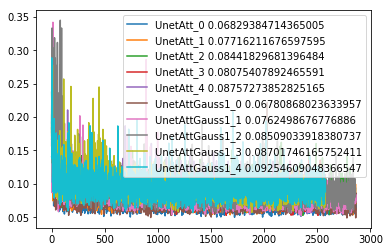

In [8]:
for model, dataset_name, i, loss in losses:
    plt.plot(loss, label=model+"_{} {}".format(i, np.mean(loss[-100:])))
    
plt.legend()

In [9]:
import pandas as pd

res = pd.DataFrame.from_records(save_res, columns=['Model', 'DS_train', 'split_no', 'MAE', 'Corr', 'Dist'])
res

,Model,DS_train,split_no,MAE,Corr,Dist
0,UnetAtt,YL1_UKM,0,0.069019,0.870262,188.483688
1,UnetAtt,YL1_UKM,1,0.065486,0.880833,179.463333
2,UnetAtt,YL1_UKM,2,0.062653,0.886334,162.136520
3,UnetAtt,YL1_UKM,3,0.064297,0.883777,164.413956
4,UnetAtt,YL1_UKM,4,0.065894,0.874163,154.371445
5,UnetAttGauss1,YL1_UKM,0,0.075738,0.860920,99.915100
6,UnetAttGauss1,YL1_UKM,1,0.068846,0.876623,79.586044
7,UnetAttGauss1,YL1_UKM,2,0.067794,0.875503,69.189491
8,UnetAttGauss1,YL1_UKM,3,0.084359,0.827551,107.359138
9,UnetAttGauss1,YL1_UKM,4,0.075373,0.845007,78.423012


In [10]:
save_res

[['UnetAtt', 'YL1_UKM', 0, 0.06901871, 0.8702623, 188.48369],
 ['UnetAtt', 'YL1_UKM', 1, 0.065486185, 0.88083285, 179.46333],
 ['UnetAtt', 'YL1_UKM', 2, 0.062653, 0.88633406, 162.13652],
 ['UnetAtt', 'YL1_UKM', 3, 0.064297386, 0.8837772, 164.41396],
 ['UnetAtt', 'YL1_UKM', 4, 0.06589429, 0.8741626, 154.37144],
 ['UnetAttGauss1', 'YL1_UKM', 0, 0.07573813, 0.8609198, 99.9151],
 ['UnetAttGauss1', 'YL1_UKM', 1, 0.068846375, 0.87662286, 79.586044],
 ['UnetAttGauss1', 'YL1_UKM', 2, 0.067793585, 0.87550265, 69.18949],
 ['UnetAttGauss1', 'YL1_UKM', 3, 0.08435896, 0.82755125, 107.35914],
 ['UnetAttGauss1', 'YL1_UKM', 4, 0.07537316, 0.8450072, 78.42301]]

In [11]:
res.groupby('Model').mean()

,split_no,MAE,Corr,Dist
Model,,,,
UnetAtt,2,0.065470,0.879074,169.773788
UnetAttGauss1,2,0.074422,0.857121,86.894557
